In [ ]:
# 드라이브 연동 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


------
# 1. 필요 라이브러리 불러오기 

-------

In [ ]:
# 라이브러리 불러오기
import cv2
import dlib
import os
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.1.2
19.18.0


------
# 2. 이미지 불러오기 

-------

득점왕을 기념해 손흥민의 사진을 활용하려한다.

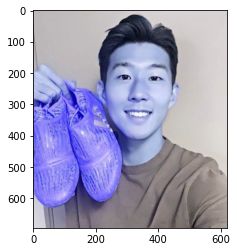

In [ ]:
my_image_path = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/sonny2.jpeg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

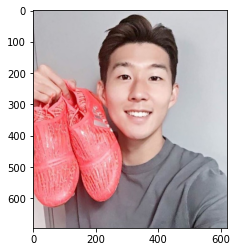

In [ ]:
# RGB값으로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [ ]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

In [ ]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

------
# 3. 얼굴 영역 검출 

-------

rectangles[[(200, 142) (468, 409)]]


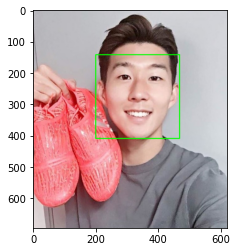

In [ ]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

------
# 4. 랜드마크 검출 

-------

In [ ]:
# 저장한 Landmark 모델 불러오기 
model_path = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [ ]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


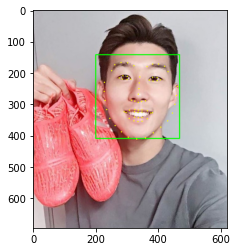

In [ ]:
# 랜드마크 영상 출력 
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

붙일 이미지가 고양이 수염이기 때문에 코 끝인 33번에 설정

In [ ]:
# 좌표 먼저 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 붙일 이미지가 고양이 수염이기 때문에 
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(336, 268)
(x,y) : (336,134)
(w,h) : (269,269)


In [ ]:
# 스티커 이미지 읽어서 적용 
# 이미지의 크기 
sticker_path = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 269, 3)


In [ ]:
# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (202,134)


In [ ]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (202,134)


------
# 5. 스티커 적용하기 

-------

In [ ]:
# 원본 이미지에 스티커를 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

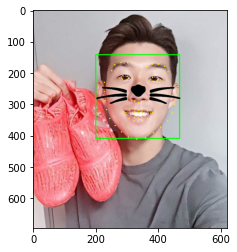

In [ ]:
# 결과 이미지 출력 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

랜드마크 및 얼굴 인식 박스 제거한 이미지 추출

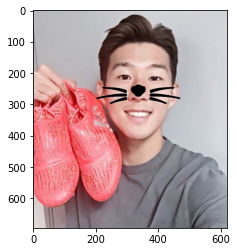

In [ ]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

------
# 6. 다른 이미지에 적용하기
------

손흥민의 다른 이미지를 가져왔다. 고개가 기울어져 있어서 스티커를 붙일 때 회전이 필요할 것 같다.

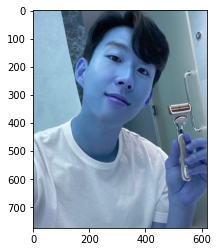

In [ ]:
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/sonny1.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr2)
plt.show()

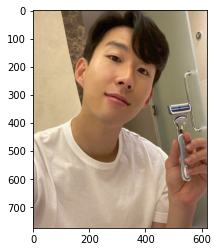

In [ ]:
# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb2)
plt.show()

In [ ]:
# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

rectangles[[(171, 112) (438, 379)]]


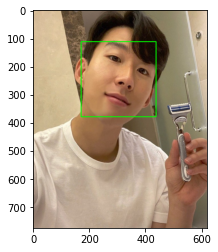

In [ ]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects2)   

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

In [ ]:
# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)


In [ ]:
list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

print(len(list_landmarks2[0]))

68


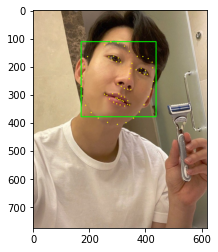

In [ ]:
# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

In [ ]:
# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

(325, 278)
(x2,y2) : (325,144)
(w2,h2) : (268,268)


In [ ]:
# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

(268, 268, 3)


In [ ]:
# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

(x2,y2) : (191,144)



## 6-1 스티커 회전 값 추출

<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png">

<img src="https://t1.daumcdn.net/cfile/tistory/215E2C45551367932A">

랜드마크를 보면 입의 가장 왼쪽 번호가 48번 반대로 가장 오른쪽 번호는 54번 이다.  

48번과 54번의 좌표를 알 수 있으며, 해당 좌표를 토대로 직각을 이루는 삼각형을 그릴 수 있으며  
각 변의 길이또한 알 수 있다. 변의 길이를 안다면 math함수 중 atan2를 통해서 각도를 구할 수 있다. 

즉, 전체 입의 기울기를 구해서 이미지 스티커에 기울기를 적용하면 고개를 기울였을때 각도처럼 이미지 스티커를 기울일 수 있다.

+) 추가적으로 입이 아닌 얼굴 형태의 좌우 가장자리인 1번과 15번 또는 2번과 14번을 통해서도 구할 수 있을 것이다.

In [ ]:
def rota(landmark):
  a = landmark[48][0] # 입 왼쪽 좌표의 x값
  b = landmark[48][1] # 입 왼쪽 좌표의 y값
  c = landmark[54][0] # 입 오른쪽 좌표의 x값
  d = landmark[54][1] # 입 오른쪽 좌표의 y값

  ac = a - c # 양 좌표의 가로 길이
  bd = b - d # 양 좌표의 세로 길이

  import math

  PI = math.pi # 파이값
  deg = - math.sin(bd/ac)* 180 / PI
  return deg

cv2.getRotaionMatrix2D(돌릴 중심축, 각도, 크기 비율)  
cv2.warpAffine(원본이미지,cv2.getRotaionMatrix2D로 변환한 아핀 맵 행렬, 출력 이미지 크기)

In [ ]:
height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

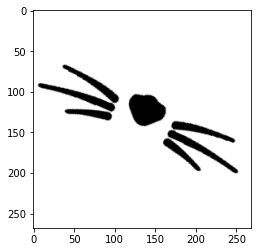

In [ ]:
plt.imshow(rotation2)

In [ ]:
if refined_x2 < 0: 
    rotation2 = rotation2[:, -refined_x2:]
    refined_x2 = 0
if refined_y2 < 0:
    rotation2 = rotation2[-refined_y2:, :]
    refined_y2 = 0

print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

(x2,y2) : (191,144)


In [ ]:
# 원본 이미지에 스티커를 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식
sticker_area2 = img_show2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_show2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)

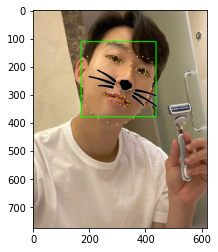

In [ ]:
# 결과 이미지 출력 
plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

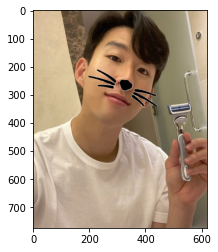

In [ ]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

-----
# 7. 캐릭터 이미지 테스트
-----

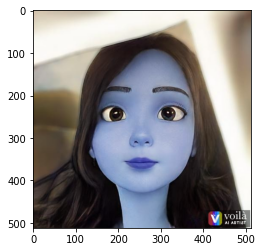

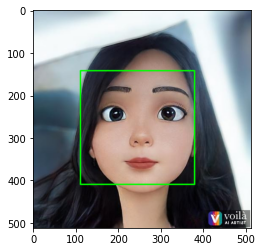

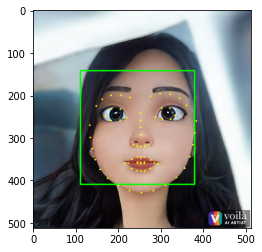

(253, 320)
(x2,y2) : (253,186)
(w2,h2) : (269,269)
(269, 269, 3)
(x2,y2) : (119,186)


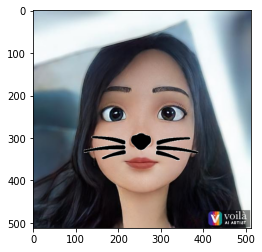

In [ ]:
# 이미지 불러오기 
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/character.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr2)
plt.show()


# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)


# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)

list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

이목구비가 또렷하게 나오는 캐릭터 이미지에도 잘 적응이 되는 것을 확인할 수 있다.

--------
# 8. 다양한 테스트
-----

## 8-1 기울어진 얼굴 테스트

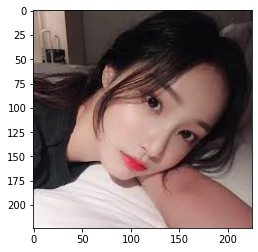

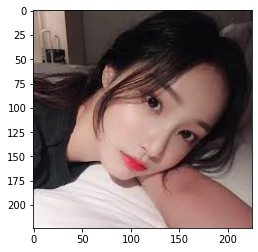

(187, 187, 3)
(x2,y2) : (474,536)


ValueError: ignored

In [ ]:
# 이미지 불러오기 
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/test_1.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다


# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)


# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)

list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

얼굴의 이목구비가 또렷하게 잘 나왔으나, 얼굴의 각도가 45도 정도 기울어져 있다보니 Landmark가 인식을 하지 못하는 문제가 발생하였다.

## 8-2 원거리 얼굴 테스트

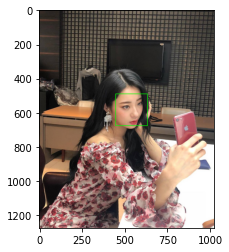

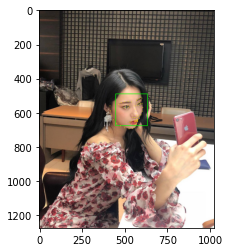

(567, 629)
(x2,y2) : (567,536)
(w2,h2) : (187,187)
(187, 187, 3)
(x2,y2) : (474,536)


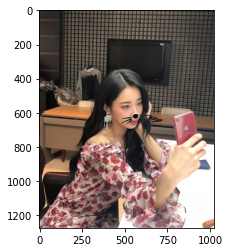

In [ ]:
# 이미지 불러오기 
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/test_2.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다



# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)


# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)

list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

이전 사진들 보다 상대적으로 먼거리에 있는 얼굴도 잘 인식하는 것을 볼 수 있다.

## 8-3 일그러진 얼굴 테스트 

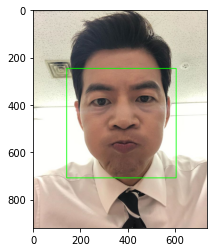

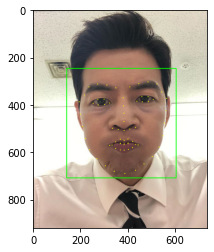

(385, 508)
(x2,y2) : (385,277)
(w2,h2) : (464,464)
(464, 464, 3)
(x2,y2) : (153,277)


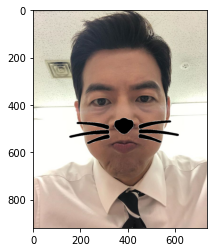

In [ ]:
# 이미지 불러오기 
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/test_3.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다



# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)


# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)

list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

볼을 부풀려 얼굴의 변형이 있어도 얼굴의 외형부터 눈,코,입 모두 잘 인식하는 것을 볼 수 있다.

## 8-4 밝은 이미지 테스트

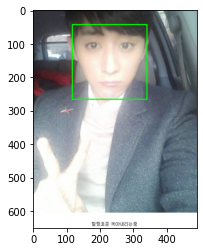

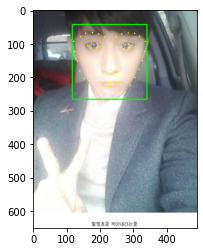

(232, 194)
(x2,y2) : (232,82)
(w2,h2) : (224,224)
(224, 224, 3)
(x2,y2) : (120,82)


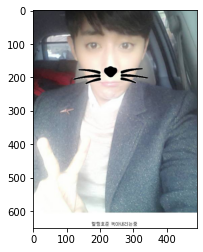

In [ ]:
# 이미지 불러오기 
my_image_path2 = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/test_4.jpeg'
img_bgr2 = cv2.imread(my_image_path2)    # OpenCV로 이미지를 불러옵니다
img_show2 = img_bgr2.copy()      # 출력용 이미지를 따로 보관합니다



# RGB값으로 변환
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)


# detector를 선언합니다
detector_hog2 = dlib.get_frontal_face_detector()
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
dlib_rects2 = detector_hog2(img_rgb2, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트

for dlib_rect2 in dlib_rects2:
    l = dlib_rect2.left()
    t = dlib_rect2.top()
    r = dlib_rect2.right()
    b = dlib_rect2.bottom()

    cv2.rectangle(img_show2, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb2 =  cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 저장한 Landmark 모델 불러오기 
landmark_predictor2 = dlib.shape_predictor(model_path)

list_landmarks2 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect2 in dlib_rects2:
    points2 = landmark_predictor2(img_rgb2, dlib_rect2)
    # face landmark 좌표를 저장해둡니다
    list_points2 = list(map(lambda p: (p.x, p.y), points2.parts()))
    list_landmarks2.append(list_points2)

# 랜드마크 영상 출력 
for landmark2 in list_landmarks2:
    for point2 in landmark2:
        cv2.circle(img_show2, point2, 2, (0, 255, 255), -1)

img_show_rgb2 = cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb2)
plt.show()

# 좌표 먼저 확인
for dlib_rect2, landmark2 in zip(dlib_rects2, list_landmarks2):
    print (landmark2[33]) # 코의 index는 30 입니다
    x2 = landmark2[33][0]
    y2 = landmark2[33][1] - dlib_rect2.height()//2
    w2 = h2 = dlib_rect2.width()
    print ('(x2,y2) : (%d,%d)'%(x2,y2))
    print ('(w2,h2) : (%d,%d)'%(w2,h2))

# 스티커 이미지 읽어서 적용 
img_sticker2 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker2 = cv2.resize(img_sticker2, (w2,h2))
print (img_sticker2.shape)

# 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
refined_x2 = x2 - w2 // 2
refined_y2 = y2
print ('(x2,y2) : (%d,%d)'%(refined_x2, refined_y2))

height, width, channel = img_sticker2.shape
rotation1 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark2),1)
rotation2 = cv2.warpAffine(img_sticker2,rotation1,(width,height), borderValue = [255,255,255])
# bordervalue매서드를 넣어 회전 후 배경이 남는 값 제거 

# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area2 = img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]]
img_bgr2[refined_y2:refined_y2+rotation2.shape[0], refined_x2:refined_x2+rotation2.shape[1]] = \
    np.where(rotation2==255,sticker_area2,rotation2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB))
plt.show()

빛으로 인해 얼굴의 외곽이 흐려졌음에도 불구하고 landmark가 잘 인식하는 것을 볼 수 있다.

-----
# 9. 영상 인식 테스트
-------
짧은 영상에서도 잘 인식하는지 확인하고자 3초짜리 영상을 가져와 테스트 해보겠다.

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow

filePath = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/zzal.mp4'
print(filePath)

if os.path.isfile(filePath):	# 해당 파일이 있는지 확인
    # 영상 객체(파일) 가져오기
    cap = cv2.VideoCapture(filePath)
else:
    print("파일이 존재하지 않습니다.")  

# 프레임을 정수형으로 형 변환
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))	# 영상의 넓이(가로) 프레임
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))	# 영상의 높이(세로) 프레임
 
frame_size = (frameWidth, frameHeight)
print('frame_size={}'.format(frame_size))

frameRate = 2


/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/zzal.mp4
frame_size=(640, 532)


cv2.VideoWriter('저장될 동영상 파일 이름', 동영상 저장시 사용되는 코덱, 영상의 초당 프레임 수[1초에 30장], (저장할 영상의 크기[캡쳐되는 이미지 크기와 일치]))

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('output.avi',fourcc,30.0,(640,532))

while True:
  # 한 장의 이미지(frame)를 가져오기
  # 영상 : 이미지(프레임)의 연속
  # 정상적으로 읽어왔는지 -> retval
  # 읽어온 프레임 -> frame
  retval, frame = cap.read()
  
  if not(retval):	# 프레임정보를 정상적으로 읽지 못하면
      break  # while문을 빠져나가기
      
  detector_hog3 = dlib.get_frontal_face_detector() 
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  dlib_rects3 = detector_hog3(frame, 1) 

  for dlib_rect3 in dlib_rects3:
    l = dlib_rect3.left()
    t = dlib_rect3.top()
    r = dlib_rect3.right()
    b = dlib_rect3.bottom()

    cv2.rectangle(frame, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
  
  landmark_predictor3 = dlib.shape_predictor(model_path)
  list_landmarks3 = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
  for dlib_rect3 in dlib_rects3:
      points3 = landmark_predictor3(frame, dlib_rect3)
      # face landmark 좌표를 저장해둡니다
      list_points3 = list(map(lambda p: (p.x, p.y), points3.parts()))
      list_landmarks3.append(list_points3)

  # 좌표 먼저 확인
  for dlib_rect3, landmark3 in zip(dlib_rects3, list_landmarks3):
      print (landmark3[30]) # 코의 index는 30 입니다
      x3 = landmark3[30][0]
      y3 = landmark3[30][1] - dlib_rect3.height()//2
      w3 = h3 = dlib_rect3.width()
      print ('(x3,y3) : (%d,%d)'%(x3,y3))
      print ('(w3,h3) : (%d,%d)'%(w3,h3))

  # 스티커 이미지 읽어서 적용 
  # sticker_path = '/content/drive/MyDrive/aiffel/Exp8/camera_sticker/images/king.png'
  img_sticker3 = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
  img_sticker3 = cv2.resize(img_sticker3, (w3,h3))

  height, width, channel = img_sticker3.shape
  rotation3 = cv2.getRotationMatrix2D((width/2,height/2),rota(landmark3),1)
  rotation4 = cv2.warpAffine(img_sticker3,rotation3,(width,height), borderValue = [255,255,255])

  # 이미지 추가를 위해 X,Y 좌표를 조정, 이미지 시작점은 TOP-LEFT 좌표
  refined_x3 = x3 - w3 // 2
  refined_y3 = y3
  # print ('(x,y) : (%d,%d)'%(refined_x3, refined_y3))

  sticker_area3 = frame[refined_y3:refined_y3+rotation4.shape[0], refined_x3:refined_x3+rotation4.shape[1]]
  frame[refined_y3:refined_y3+rotation4.shape[0], refined_x3:refined_x3+rotation4.shape[1]] = \
    np.where(rotation4==255,sticker_area3,rotation4).astype(np.uint8)

  cv2_imshow(frame)	# 프레임 보여주기
  key = cv2.waitKey(frameRate)  # frameRate msec동안 한 프레임을 보여준다
  
  writer.write(frame)

    # 키 입력을 받으면 키값을 key로 저장 -> esc == 27(아스키코드)
  if key == 27:
    break	# while문을 빠져나가기
        
if cap.isOpened():	# 영상 파일(카메라)이 정상적으로 열렸는지(초기화되었는지) 여부
    cap.release()	# 영상 파일(카메라) 사용을 종료

writer.release()

cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

만든 영상을 볼 수 있는 링크 https://drive.google.com/file/d/1LAhGao9dBjrwxegwqLgd8Y8D3z64EM5R/view?usp=sharing

-----
# 10. 회고
--------

- 다양한 이미지를 넣어 landmark가 잘 인식하는지 테스트를 진행하였다.  

- 캐릭터 이미지 / 원거리 이미지 / 일그러진 이미지 / 빛 번짐 이미지 모두 잘 인식하는 것을 볼 수 있다. 다만, 기울어진 이미지는 인식을 못한다. 해당 이유에 대해서 찾아본 결과 이미지를 인식하는 방식에는 지식 기반 / 템플릿 매칭 기반 / 특징 기반 / 외형 기반 등등 으로 나누어 지는데 해당 모델은 hog와 svm를 사용하는 외형 기반 모델로 추측 된다. 해당 알고리즘을 기반으로는 기울어진 얼굴 인식을 불가능 하나 타 알고리즘을 기반으로 할 때는 기울어진 얼굴도 인식이 가능할 것이라 생각한다.   참고 블로그<http://www.cctvnews.co.kr/news/articleView.html?idxno=591>

- 스티커 이미지 회전에 대한 값을 구하기 위해 인터넷을 찾아보니 landmark의 27번 30번을 활용해 호도법을 이용한 사람도 있었고, 스티커를 얼굴의 절반씩 나누어 적용하는 사람의 코드도 보았다. 다양한 사람들의 접근법을 보는 과정이 다소 재밌게 느껴졌다. 

- 스티커 이미지의 평면 회전은 기울기 값을 구해서 돌리면 되지만... 얼굴 회전에 따른 스티커 이미지의 z축 회전(?)은 코드가 다소 복잡해 시도해보지는 못했다. 현재 내용들도 완벽한 이해를 하지 못한 상태이기 때문에 추후 이해도가 올라간다면 시도해 보겠다.